# Train Model with CPU

In [27]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

## Reset TensorFlow Graph
Useful in Jupyter Notebooks

In [28]:
tf.reset_default_graph()

## Create TensorFlow Session

In [29]:
sess = tf.Session()
print(sess)

In [30]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

### Load Model Training and Test/Validation Data 


In [31]:
num_samples = 100000

[ 0.59475684  0.59075665  0.31616342 ...,  0.50955987  0.13376965
  0.38082409]
[ 0.35664647  0.35132487  0.31321464 ...,  0.35458749  0.31171552
  0.33892754]


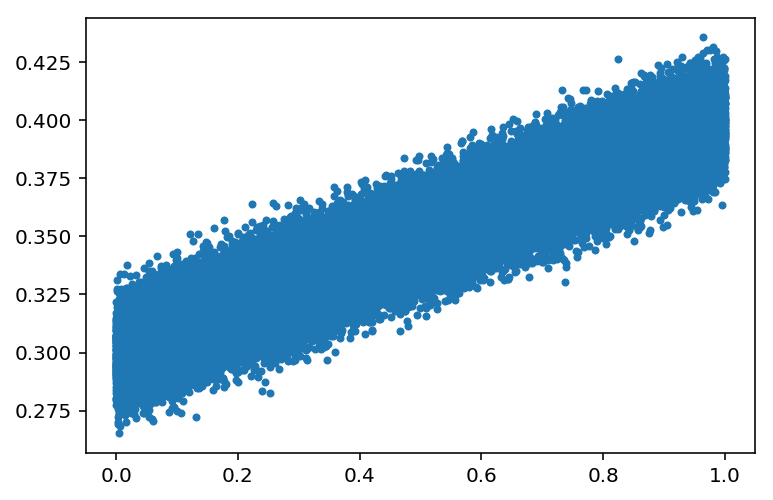

In [32]:
x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

pylab.plot(x_train, y_train, '.')

[ 0.0584635   0.86828977  0.05742929 ...,  0.23893836  0.60162991
  0.07499118]
[ 0.30370643  0.39007239  0.3132881  ...,  0.33433678  0.33960324
  0.30510281]


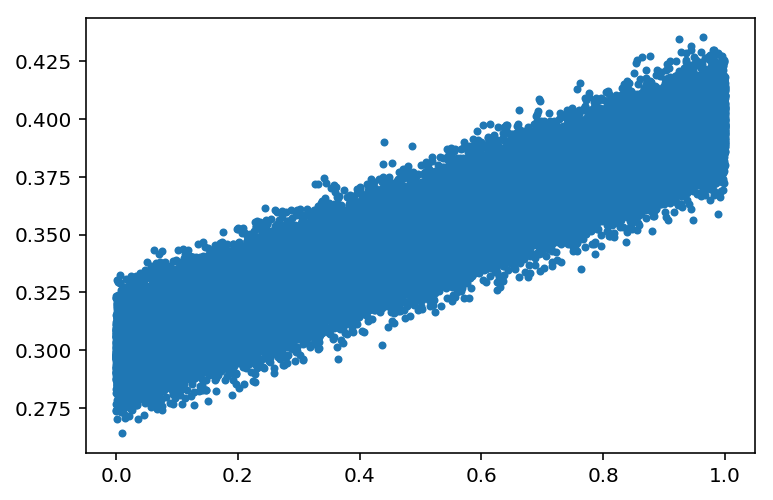

In [33]:
x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_test, y_test, '.')

In [34]:
with tf.device("/cpu:0"):
    W = tf.get_variable(shape=[], name='weights')
    print(W)

    b = tf.get_variable(shape=[], name='bias')
    print(b)

    x_observed = tf.placeholder(shape=[None], 
                                dtype=tf.float32, 
                                name='x_observed')
    print(x_observed)

    y_pred = W * x_observed + b
    print(y_pred)

<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:CPU:0)


In [35]:
learning_rate = 0.025

with tf.device("/cpu:0"):
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))
    optimizer_op = tf.train.GradientDescentOptimizer(learning_rate)
    
    train_op = optimizer_op.minimize(loss_op)  

    print("Loss Scalar: ", loss_op)
    print("Optimizer Op: ", optimizer_op)
    print("Train Op: ", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Loss Scalar:  Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)
Optimizer Op:  <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7fa9546360b8>
Train Op:  name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



## Randomly Initialize Variables (Weights and Bias)
The goal is to learn more accurate Weights and Bias during training.

In [36]:
with tf.device("/cpu:0"):
    init_op = tf.global_variables_initializer()
    print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [37]:
sess.run(init_op)
print("Initial random W: %f" % sess.run(W))
print("Initial random b: %f" % sess.run(b))

Initial random W: 1.444410
Initial random b: -0.703968


## View Model Graph in Tensorboard

http://[ip-address]:6006

## View Accuracy of Pre-Training, Initial Random Variables
This should be relatively low.

In [38]:
def test(x, y):
    return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [39]:
test(x_train, y_train)

0.26194996

## Setup Loss Summary Operations for Tensorboard

In [40]:
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

In [41]:
train_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/train' % version, 
                                            graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('/root/tensorboard/linear/cpu/%s/test' % version,
                                            graph=tf.get_default_graph())

## Train Model

In [42]:
%%time

with tf.device("/cpu:0"):
    run_metadata = tf.RunMetadata()
    max_steps = 401
    for step in range(max_steps):
        if (step < max_steps - 1):
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
        else:  
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, 
                                            options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), 
                                            run_metadata=run_metadata)

            trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
            with open('cpu-timeline.json', 'w') as trace_file:
                trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

        if step % 10 == 0:
            print(step, sess.run([W, b]))
            train_summary_writer.add_summary(train_summary_log, step)
            train_summary_writer.flush()
            test_summary_writer.add_summary(test_summary_log, step)
            test_summary_writer.flush()

0 [1.4470718, -0.68736273]
10 [1.4528111, -0.56241816]
20 [1.4345145, -0.48610932]
30 [1.4044226, -0.43544298]
40 [1.3688729, -0.3984594]
50 [1.3311362, -0.36893284]
60 [1.2928911, -0.34361699]
70 [1.2549894, -0.32081404]
80 [1.2178538, -0.2996313]
90 [1.1816844, -0.27959472]
100 [1.1465673, -0.26044786]
110 [1.1125292, -0.24204813]
120 [1.0795665, -0.22431211]
130 [1.04766, -0.2071874]
140 [1.0167845, -0.19063812]
150 [0.9869107, -0.17463723]
160 [0.95800793, -0.15916254]
170 [0.9300459, -0.14419466]
180 [0.90299463, -0.12971587]
190 [0.87682474, -0.11570969]
200 [0.85150778, -0.10216038]
210 [0.82701576, -0.089052871]
220 [0.80332202, -0.076372676]
230 [0.78040051, -0.064105831]
240 [0.75822616, -0.052238841]
250 [0.73677456, -0.040758666]
260 [0.71602213, -0.029652694]
270 [0.69594616, -0.018908719]
280 [0.67652446, -0.008514924]
290 [0.65773588, 0.0015400869]
300 [0.63955963, 0.011267358]
310 [0.62197596, 0.020677567]
320 [0.60496545, 0.029781044]
330 [0.58850932, 0.038587783]
340 

(0, 1.0)

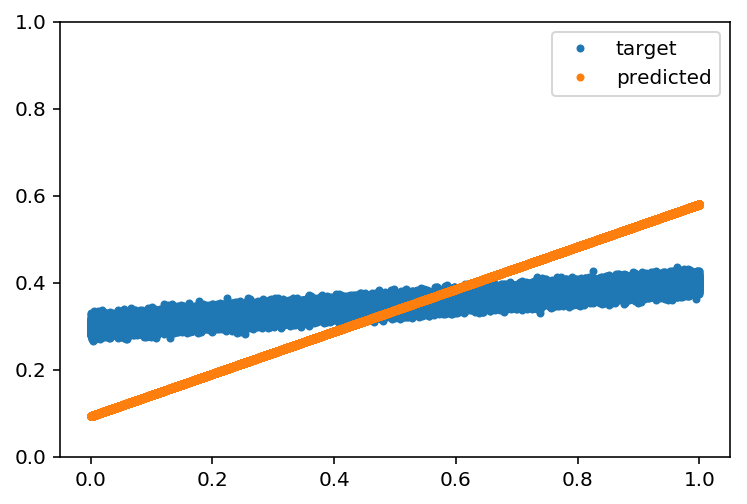

In [43]:
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, 
                             feed_dict={x_observed: x_train, 
                                        y_observed: y_train}), 
           ".", 
           label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

## View Loss Summaries in Tensorboard

Navigate to the Scalars tab at this URL:

http://[ip-address]:6006

## Save Model for Deployment and Inference

In [46]:
from tensorflow.python.saved_model import utils

tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

name: "x_observed:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}

name: "add:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}



In [47]:
saved_model_path = '/root/models/linear/cpu/%s' % version

print(saved_model_path)

/root/models/linear/cpu/1494613814


In [48]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants

builder = saved_model_builder.SavedModelBuilder(saved_model_path)

prediction_signature =  signature_def_utils.build_signature_def(inputs = 
                        {'x_observed': tensor_info_x_observed}, 
                        outputs = {'y_pred': tensor_info_y_pred}, 
                        method_name = signature_constants.PREDICT_METHOD_NAME)

legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING],
                                     signature_def_map={'predict':prediction_signature, signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
                                     legacy_init_op=legacy_init_op)

builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'/root/models/linear/cpu/1494613814/saved_model.pb'


b'/root/models/linear/cpu/1494613814/saved_model.pb'

### View Saved Model on Disk
Replace `[version]` with version number from above.

In [50]:
%%bash

# Replace `[version]` with version number from above
ls -l /root/models/linear/cpu/[version]

total 28
-rw-r--r-- 1 root root 21800 May 12 18:30 saved_model.pb
drwxr-xr-x 2 root root  4096 May 12 18:30 variables


## Save Graph For Optimization
We will use this later.

In [ ]:
from tensorflow.python.framework import graph_io

#graph_io.write_graph(sess.graph, 
#                     "/root/models/optimize_me/", 
#                     "unoptimized_cpu.pb",
#                     as_text=False)

In [ ]:
#from tensorflow.python.training import saver as saver_lib

#saver = saver_lib.Saver()
    
#checkpoint_path = saver.save(sess,
#                             "model.ckpt",
#                             global_step=0,
                             #latest_filename="latest")


In [44]:
import os

saver = tf.train.Saver()

optimize_me_path = '/root/models/linear/optimize_me/cpu/unoptimized'
print(optimize_me_path)

if not os.path.exists(optimize_me_path):
    os.makedirs(optimize_me_path)

tf.add_to_collection('input_tensor', x_observed)
tf.add_to_collection('output_tensor', y_pred)
tf.add_to_collection('weights_tensor', W)
tf.add_to_collection('bias_tensor', b)

saver.save(sess, optimize_me_path,
             global_step=max_steps)


/root/models/linear/optimize_me/cpu/unoptimized


'/root/models/linear/optimize_me/cpu/unoptimized-401'

In [ ]:
%%bash

freeze_graph --input_graph=/root/models/optimize_me/unoptimized_cpu.pb \
             --input_checkpoint=/root/notebooks/model.ckpt-0 \
             --output_graph=blah.pb \
             --output_node_names=add \
             --input_binary=True

In [ ]:
optimize_export_path = '/root/models/linear/optimize_me/cpu/'

print(optimize_export_path)


In [ ]:
from tensorflow.python.saved_model import utils

tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

In [ ]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants


builder = saved_model_builder.SavedModelBuilder(optimized_export_path)

prediction_signature =  signature_def_utils.build_signature_def(inputs = 
                        {'x_observed': tensor_info_x_observed}, 
                        outputs = {'y_pred': tensor_info_y_pred}, 
                        method_name = signature_constants.PREDICT_METHOD_NAME)

legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')

builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING],
                                     signature_def_map={'predict':prediction_signature, signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
                                     legacy_init_op=legacy_init_op)

builder.save()

In [ ]:
!rm -rf /root/models/linear/cpu_fully_optimized/1494608417

In [ ]:
sess.close()